**Installation of SimPy""
If not available**

In [986]:
#%pip install simpy
#%pip install numpy
#%pip install matplotlib
#%pip install roundrobin
#pip install pandas

**Import of required modules**

In [987]:
import simpy
import numpy as np
import numpy.random as random
import pandas as pd

**Parameters settings**

In [988]:
MAXSIMTIME = 50000
VERBOSE = False
LAMBDA = 3.8
MU = 8.0
POPULATION = 50000000
SERVICE_DISCIPLINE = ['FIFO', 'RR']
LOGGED = True
PLOTTED = True
TIME_SLICE = 0.5
qlogs = dict()

In [989]:
if LOGGED:
    for service in SERVICE_DISCIPLINE:
        qlogs[service] = open(f'mm1-{service}-l{LAMBDA}-m{MU}.csv', 'w+')
        qlogs[service].write('0\t0\t0\t0\n')

In [990]:
def SJF( job ):
    return job.duration

In [991]:
class Job:
    def __init__(self, name, arrtime, duration):
        self.name = name
        self.arrtime = arrtime
        self.duration = duration
        self.bursttime = duration

    def __str__(self):
        return '%s at %d, length %d' %(self.name, self.arrtime, self.duration)

In [992]:
class Server:
    def __init__(self, env, strat = 'FIFO'):
        self.env = env
        self.strat = strat
        self.Jobs = list(())
        self.serversleeping = None
        ''' statistics '''
        self.waitingTime = 0
        self.turnAroundTime = 0
        self.numberInSys = 0
        self.idleTime = 0
        self.jobsDone = 0
        self.last = 0
        ''' register a new server process '''
        self.env.process( self.serve() )

    def serve(self):
        while True:
            ''' do nothing, just change server to idle
              and then yield a wait event which takes infinite time
            '''
            if len( self.Jobs ) == 0 :
                self.serversleeping = self.env.process( self.waiting())
                t1 = self.env.now
                yield self.serversleeping
                ''' accumulate the server idle time'''
                self.idleTime += self.env.now - t1
            else:
                ''' get the first job to be served'''
                if self.strat == 'SJF':
                    self.Jobs.sort( key = SJF )
                    j = self.Jobs.pop( 0 )
                elif self.strat == 'RR':
                    if self.Jobs[0].duration > TIME_SLICE: 
                        self.Jobs[0].duration -= TIME_SLICE
                        j = Job(name=self.Jobs[0].name, arrtime=self.Jobs[0].arrtime, duration=TIME_SLICE)
                        self.Jobs = np.roll(self.Jobs, -1).tolist()
                    else:
                        j = self.Jobs.pop(0)
                else: # FIFO by default
                    j = self.Jobs.pop( 0 )

                nowtime = self.env.now
                waitingtime = 0
                turnaroundtime = 0
                if self.strat == 'RR':
                    if len(self.Jobs) > 0 and self.Jobs[-1].name == j.name: 
                        yield self.env.timeout( j.duration )
                    else:
                        turnaroundtime += (nowtime + j.duration) - j.arrtime
                        waitingtime += turnaroundtime - j.bursttime
                        yield self.env.timeout( j.duration )
                        self.jobsDone += 1
                else:
                    ''' sum up the waiting time'''
                    turnaroundtime += (nowtime + j.duration) - j.arrtime
                    waitingtime += nowtime - j.arrtime
                    ''' yield an event for the job finish'''
                    yield self.env.timeout( j.duration )
                    ''' sum up the jobs done '''
                    self.jobsDone += 1
                
                self.numberInSys += (self.env.now - self.last) * len(self.Jobs)
                self.last = self.env.now
                self.waitingTime += waitingtime
                self.turnAroundTime += turnaroundtime
                if LOGGED:
                    for _, qlog in qlogs.items():
                        qlog.write(f'{nowtime:.4f}\t{1 if len(self.Jobs) > 0 else 0}\t{len(self.Jobs)}\t{waitingtime}\n')

    def waiting(self):
        try:
            if VERBOSE:
                print( 'Server is idle at %.2f' % self.env.now )
            yield self.env.timeout( MAXSIMTIME )
        except simpy.Interrupt as i:
            if VERBOSE:
                 print('Server waken up and works at %.2f' % self.env.now )

In [993]:
class JobGenerator:
    def __init__(self, env, servers, nrjobs = 10000000, lam = 5, mu = 8):
        self.servers = servers
        self.nrjobs = nrjobs
        self.interarrivaltime = 1/lam
        self.servicetime = 1/mu
        self.env = env
        self.env.process( self.generatejobs() )
        
    def generatejobs(self):
        i = 1
        while True:
            '''yield an event for new job arrival'''
            job_interarrival = random.exponential( self.interarrivaltime )
            yield self.env.timeout( job_interarrival )

            ''' generate service time and add job to the list'''
            job_duration = random.exponential( self.servicetime )
            nowtime = self.env.now
            for server in self.servers:
                server.Jobs.append(Job(f'Job {i}', nowtime, job_duration))
            if VERBOSE:
                print(f'job {i}: t = {nowtime:.2f}, l = {job_duration:.2f}, dt = {job_interarrival:.2f}')
            i += 1

            ''' if server is idle, wake it up'''
            for server in self.servers:
                if not server.serversleeping.triggered:
                    server.serversleeping.interrupt( 'Wake up, please.' )


In [994]:
np.random.seed(0)
env = simpy.Environment()
servers = [Server(env, service) for service in SERVICE_DISCIPLINE]
_ = JobGenerator(env, servers, POPULATION, LAMBDA, MU )
env.run( until = MAXSIMTIME )

In [995]:
if LOGGED:
    for _, qlog in qlogs.items():
        qlog.close()

In [996]:
RHO = LAMBDA/MU
data = {
    'Simulation'                : [ 'Theory', 'M/M/1', 'RR',],
    'Arrivals'                  : [servers[0].jobsDone, servers[0].jobsDone, servers[1].jobsDone],
    'Utilization'               : [f'{RHO:.4f}', f'{1.0-servers[0].idleTime/MAXSIMTIME:.4f}', f'{1.0-servers[1].idleTime/MAXSIMTIME:.4f}'],
    'Mean spending time'        : [f'{(1/MU)/(1-RHO):.4f}', f'{servers[0].turnAroundTime/servers[0].jobsDone:.4f}', f'{servers[1].turnAroundTime/servers[1].jobsDone:.4f}'],
    'Mean number in system'     : [f'{RHO/(1-RHO):.4f}', f'{(servers[0].numberInSys + len(servers[0].Jobs) * (MAXSIMTIME - servers[0].last))/MAXSIMTIME:.4f}', f'{(servers[1].numberInSys + len(servers[1].Jobs) * (MAXSIMTIME - servers[1].last))/MAXSIMTIME:.4f}'],
    'Mean waiting time'         : [f'{RHO**2/((1-RHO)*LAMBDA):.4f}', f'{servers[0].waitingTime/servers[0].jobsDone:.4f}', f'{servers[1].waitingTime/servers[1].jobsDone:.4f}']
}
df = pd.DataFrame(data=data)
df    

,Simulation,Arrivals,Utilization,Mean spending time,Mean number in system,Mean waiting time
0,Theory,190262,0.4750,0.2381,0.9048,0.1131
1,M/M/1,190262,0.4754,0.2374,0.9034,0.1124
2,RR,190262,0.4754,0.2374,0.9270,0.1125


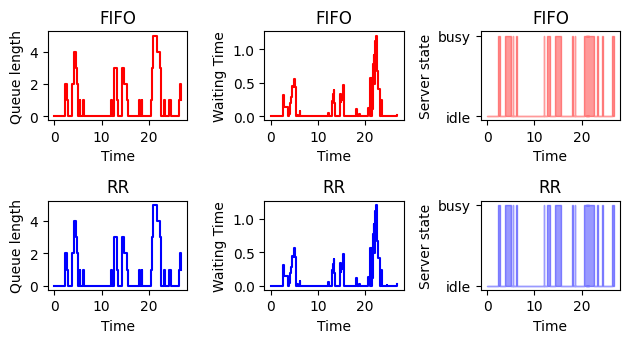

In [997]:
if LOGGED and PLOTTED:
    import matplotlib.pyplot as plt
    colors = {'FIFO': 'red', 'RR': 'blue' }
    i = 1
    for service in SERVICE_DISCIPLINE:
        log = np.loadtxt( f'mm1-{service}-l{LAMBDA}-m{MU}.csv', delimiter = '\t' )
        plt.subplot( 3, 3, i )
        plt.xlabel( 'Time' )
        plt.ylabel( 'Queue length' )
        plt.step( log[:200,0], log[:200,2], where='post', color=colors[service] )
        i += 1
        plt.title(f"{service}")

        plt.subplot( 3, 3, i )
        plt.xlabel( 'Time' )
        plt.xlabel( 'Time' )
        plt.ylabel( 'Waiting Time' )
        plt.step( log[:200,0], log[:200,3], where='post', color=colors[service] )
        i += 1
        plt.title(f"{service}")

        plt.subplot( 3, 3, i )
        plt.xlabel( 'Time' )
        plt.ylabel( 'Server state' )
        plt.yticks([0, 1], ['idle', 'busy'])
        #plt.step( log[:200,0], log[:200,1], where='post' )
        plt.fill_between( log[:200,0], 0, log[:200,1], step="post", alpha=.4, color=colors[service] )
        i += 1
        plt.tight_layout()
        plt.title(f"{service}")
    plt.show()  
